In [114]:
using DatasetManager, C3D, Biomechanics, Peaks, PlotlyJS, ProgressMeter,
    HypothesisTests, DataFrames, DataFramesMeta
using LabDataSources: V3DEvents

[ Info: Precompiling DataFramesMeta [1313f7d8-7da2-5740-9ea0-a2ca25f37964]
[ Info: Precompiling AccessorsUnitfulExt [0f33c9ce-b40b-5f58-839e-64dee873ac84]


In [4]:
includet("src/utils.jl")

In [95]:
# Define data location for all processes
diskLoc = "/mnt/data/projects"

rootdir = joinpath(diskLoc, "arm-role-stability")

ya_trials = let
ya_rawpath = joinpath(rootdir, "data", "young-adults", "raw", "ARMS_STAB")
ya_eventspath = joinpath(rootdir, "data", "young-adults", "raw", "events")

subsets = [
    DataSubset("events", Source{V3DEvents}, ya_eventspath, "subject-[0-9]*/*.tsv"),
    DataSubset("c3d", Source{C3DFile}, ya_rawpath, "Subject [0-9]*/_/*.c3d"),
]

labels = Dict(
    :arms => [ "(none|noswing)" => "held", "released", "norm", "tied",
               "excess" => "active" ],
    :kind => [ "trip", "slip", "pertub" => "perturb", "park" ],
    :symmetric => r"a?sym"
)

conds = TrialConditions((:symmetric, :kind, :arms), labels; required=(:arms,),
    subject_fmt=r"(?<=Subject[ -])(?<subject>\d+)"i, types=Dict(:subject => Int))

ignorefiles = [
    joinpath(ya_rawpath, "Subject 01/_/asym-slip-none-01.c3d"),
    joinpath(ya_rawpath, "Subject 01/_/asym-trip-none-01.c3d"),
    joinpath(ya_rawpath, "Subject 01/_/asym-trip-none-02.c3d"),
    joinpath(ya_rawpath, "Subject 01/_/sym-none.c3d"),
    joinpath(ya_rawpath, "Subject 01/_/sym-norm.c3d"),
    joinpath(ya_rawpath, "Subject 01/_/sym-slip-none-01.c3d"),
    joinpath(ya_rawpath, "Subject 01/_/sym-slip-norm-01.c3d"),
    joinpath(ya_rawpath, "Subject 01/_/sym-slip-released-01.c3d"),
    joinpath(ya_rawpath, "Subject 01/_/sym-trip-none-01.c3d"),
    joinpath(ya_rawpath, "Subject 01/_/sym-trip-norm-01.c3d"),
    joinpath(ya_rawpath, "Subject 01/_/sym-trip-released-01.c3d"),
    joinpath(ya_rawpath, "Subject 01/_/park-norm-01.c3d"),
    joinpath(ya_rawpath, "Subject 05/_/asym-pertub-noswing.c3d"),
    joinpath(ya_eventspath, "subject-08/sym-norm_repeated.tsv"),
]

trials = findtrials(subsets, conds; ignorefiles)
filter!(trials) do trial
    !hascondition(trial, :kind) &&
    hascondition(trial, :arms => "norm") &&
    hassource(trial, "events") && hassource(trial, "c3d")
end
recodecondition!.(trials, :symmetric => (s -> s == "sym" ? true : false))
trials
end

summarize(ya_trials)

Subjects:
 └ 15: 1  2  3  4  5  6  7  8  9  10  11  12  13  14  15
Trials:
 ├ 29 trials
 └ Trials per subject:
   ├ 2: 14 subjects (93%)
   └ 1: 1 subject (7%)
Conditions:
 ├ Observed levels:
 │ ├ symmetric => Bool[0, 1]
 │ └ arms => ["norm"]
 └ Unique level combinations observed: 2 (full factorial)
     symmetric │ arms │ # trials 
    ───────────┼──────┼──────────
         false │ norm │ 15       
          true │ norm │ 14       
Sources:
 ├ "events" => Source{V3DEvents}, 29 trials (100%)
 └ "c3d" => Source{C3DFile}, 29 trials (100%)


In [54]:
pd_trials = let
rawpath = joinpath(rootdir, "data", "parkinsons", "raw")

subsets = [
    DataSubset("c3d", Source{C3DFile}, joinpath(rawpath, "PD_ARMS_STAB"), "Subject */_/*.c3d"),
    DataSubset("events", Source{V3DEvents}, joinpath(rawpath, "events"), "subject-[0-9]*/*.tsv")
]
labels = Dict(
    :arms => [ ["NONE", "NA"] => "held",
               ["AS", "Norm", "NORM", "normal"] => "norm"],
    :task => [ ["(?<=NONE|NORM|held|norm)S", "BA", "PO", "single(?!task)"] => "single",
               ["(?<=NONE|NORM|norm|held)C", "CO", "CP", "dual(?!task)"] => "dual",
               ["PARK", "(?<=_)TR(?=_)"] => "park" ],
    :pert_side => [ ["[Rr](?=[ST]|(?i:slip|trip))", "RIGHT"] => "right",
                    ["[Ll](?=[ST]|(?i:slip|trip))", "LEFT"] => "left"],
    :pert_type => [ "(?i:(?<=[RL]|right|left))T(RIP)?" => "trip",
                    "(?i:(?<=[RL]|right|left))S(LIP)?" => "slip"])

conds = TrialConditions((:arms,:task,:pert_side,:pert_type), labels;
    subject_fmt=r"(?:Subject |N|subject-)0?(?<subject>\d+)", required=(:arms,:task))

# Read all perturbations
trials = findtrials(subsets, conds;
     ignorefiles = [
        joinpath(rawpath, "PD_ARMS_STAB", "Subject 08/_/held_single_ltrip.c3d"),
    ])

filter!(trials) do trial
    !hascondition(trial, :pert_side, :pert_type) &&
    hascondition(trial, :arms => "norm", :task => ["single", "dual"]) &&
    hassource(trial, "events")
end

trials
end
summarize(pd_trials)

Subjects:
 └ 20: "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  …  "16"  "17"  "18"  "19"  "20"
Trials:
 ├ 40 trials
 └ Trials per subject:
   └ 2: 20 subjects (100%)
Conditions:
 ├ Observed levels:
 │ ├ task => ["dual", "single"]
 │ └ arms => ["norm"]
 └ Unique level combinations observed: 2 (full factorial)
       task │ arms │ # trials 
    ────────┼──────┼──────────
       dual │ norm │ 20       
     single │ norm │ 20       
Sources:
 ├ "events" => Source{V3DEvents}, 40 trials (100%)
 └ "c3d" => Source{C3DFile}, 40 trials (100%)


In [136]:
function evaluatepredictions(alg, trial)
    seg = Segment(trial, "events")
    segr = SegmentResult(seg)
    res = results(segr)
    
    events = readsegment(seg)
    pred = alg(trial)
    @assert keys(pred) ⊆ keys(events)
    
    for event in keys(pred)
        _, idxs, dists, missed = matchevents(pred[event], events[event])
        res[event*"_idxs"] = idxs
        res[event*"_err"] = dists
        res[event*"_miss"] = missed
        
        ev_diff = diff(pred[event])
        ev_qtl = quantile(ev_diff, [0.25,0.5,0.75])
        res[event*"_outlyr"] = filter(
            >(ev_qtl[2]+ev_qtl[3]-ev_qtl[1])∘abs, ev_diff .- ev_qtl[2])
    end
    res["FC_err"] = vcat(res["LFC_err"], res["RFC_err"])
    res["FO_err"] = vcat(res["LFO_err"], res["RFO_err"])
    res["FC_miss"] = vcat(res["LFC_miss"], res["RFC_miss"])
    res["FO_miss"] = vcat(res["LFO_miss"], res["RFO_miss"])

    res["mean_stride_error"] = diff(events["RFC"][res["RFC_idxs"]]) .- 
        diff(events["RFC"][res["RFC_idxs"]] .+ res["RFC_err"])
    
    return segr
end

evaluatepredictions (generic function with 1 method)

In [137]:
ya_srs = analyzedataset(ya_trials, Source{V3DEvents}) do trial
    evaluatepredictions(roerdink2008, trial)
end;
filter!(!isempty∘results, ya_srs);

Analyzing trials... 100%|███████████████████████████████| Time: 0:00:01


In [138]:
ya_stride_errs = reduce(vcat, getindex.(results.(ya_srs), "mean_stride_error"))
ya_fc_errs = reduce(vcat, getindex.(results.(ya_srs), "FC_err"))
ya_fo_errs = reduce(vcat, getindex.(results.(ya_srs), "FO_err"));

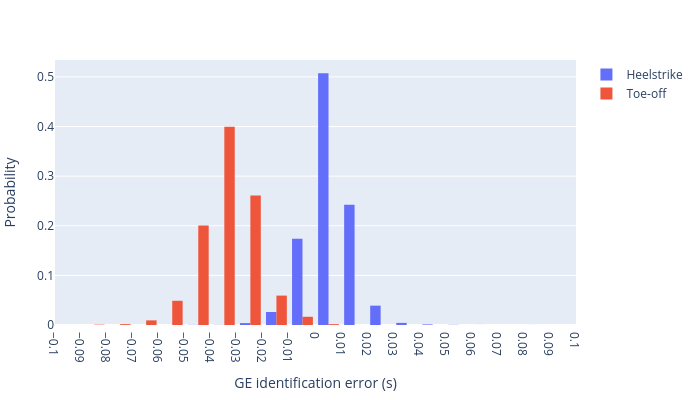

In [135]:
plot([
        histogram(;x=ya_fc_errs, xbins_size=.01, histnorm="probability", name="Heelstrike"),
        histogram(;x=ya_fo_errs, xbins_size=.01, histnorm="probability", name="Toe-off"),
    ],
    Layout(;
        xaxis_dtick=.01,
        xaxis_title="GE identification error (s)",
        yaxis_title="Probability",
        xaxis_range=[-.1,.1],
        height=400,
        width=700,
        
); config=PlotConfig(;scrollZoom=false))

In [99]:
ya_fc_test = OneSampleTTest(ya_fc_errs*1000)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          5.73808
    95% confidence interval: (5.495, 5.982)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   9980
    t-statistic:              46.182447318993034
    degrees of freedom:       9979
    empirical standard error: 0.12424798782685607


In [100]:
ya_fo_test = OneSampleTTest(ya_fo_errs*1000)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -34.6194
    95% confidence interval: (-34.84, -34.4)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   9956
    t-statistic:              -308.8620833678066
    degrees of freedom:       9955
    empirical standard error: 0.11208700367034279


In [139]:
ya_stride_errs_test = OneSampleTTest(ya_stride_errs*1000)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.338017
    95% confidence interval: (-0.02831, 0.7043)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0705

Details:
    number of observations:   4982
    t-statistic:              1.8089562010370526
    degrees of freedom:       4981
    empirical standard error: 0.18685740456554065


In [140]:
pd_srs = analyzedataset(pd_trials, Source{V3DEvents}) do trial
    evaluatepredictions(roerdink2008, trial)
end;
filter!(!isempty∘results, pd_srs);

Analyzing trials... 100%|███████████████████████████████| Time: 0:00:01


In [141]:
pd_stride_errs = reduce(vcat, getindex.(results.(pd_srs), "mean_stride_error"))
pd_fc_errs = reduce(vcat, getindex.(results.(pd_srs), "FC_err"))
pd_fo_errs = reduce(vcat, getindex.(results.(pd_srs), "FO_err"));

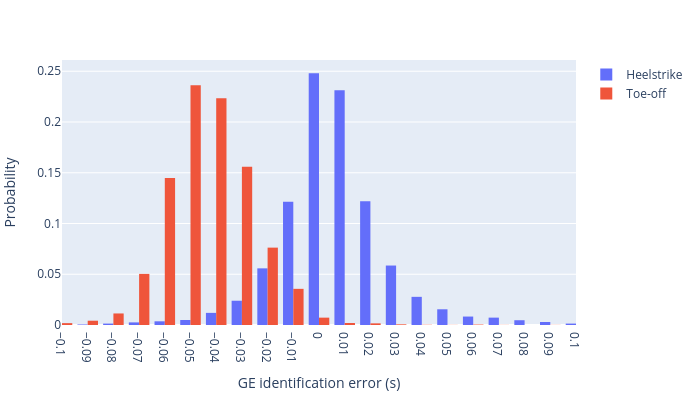

In [142]:
plot([
        histogram(;x=pd_fc_errs, xbins_size=.01, histnorm="probability", name="Heelstrike"),
        histogram(;x=pd_fo_errs, xbins_size=.01, histnorm="probability", name="Toe-off"),
    ],
    Layout(;
        xaxis_dtick=.01,
        xaxis_title="GE identification error (s)",
        yaxis_title="Probability",
        xaxis_range=[-.1,.1],
        height=400,
        width=700,
        
); config=PlotConfig(;scrollZoom=false))

In [76]:
pd_fc_test = OneSampleTTest(pd_fc_errs*1000)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          3.95219
    95% confidence interval: (2.316, 5.588)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-05

Details:
    number of observations:   9370
    t-statistic:              4.734705967422696
    degrees of freedom:       9369
    empirical standard error: 0.8347271954593368


In [77]:
pd_fo_test = OneSampleTTest(pd_fo_errs*1000)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -47.9858
    95% confidence interval: (-49.49, -46.48)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   9234
    t-statistic:              -62.59543374544853
    degrees of freedom:       9233
    empirical standard error: 0.766602456879182


In [143]:
pd_stride_errs_test = OneSampleTTest(pd_stride_errs*1000)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          1.2003
    95% confidence interval: (-0.4584, 2.859)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1561

Details:
    number of observations:   4608
    t-statistic:              1.4186776936376242
    degrees of freedom:       4607
    empirical standard error: 0.8460722437714153
